In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math
import scipy.stats as stats


import import_ipynb
from CustomDataset import ControlsDataset
from Model import ConvNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('using device', device)

importing Jupyter notebook from CustomDataset.ipynb
importing Jupyter notebook from Model.ipynb
using device cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = ControlsDataset()
dataset.labels.num_categories = 21
dataset.labels.transform.categorize(1.05, -1.05, 21)
dataset.images.set_grayscale(False)
print("Data size", len(dataset.labels))
dataset.make_dataloaders()

Data size 11019
Total training stacks 69
Total validation stacks 18


In [4]:
net = ConvNet(color_channels = 3, outputs = 21, dataset = dataset).to(device)
#net = ConvNet(color_channels = 1, outputs = 21, dataset = dataset).to(device)
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 512
conv parameters:  168224
fc parameters:  166933
number of parameters:  335157


          ID     Angle  Category
0          0 -0.000000        10
1          1 -0.000000        10
2          2 -0.000000        10
3          3 -0.000000        10
4          4 -0.000000        10
5          5 -0.000000        10
6          6 -0.000000        10
7          7 -0.000000        10
8          8 -0.000000        10
9          9 -0.000000        10
10        10 -0.000000        10
11        11 -0.000000        10
12        12 -0.000000        10
13        13 -0.000000        10
14        14 -0.000000        10
15        15 -0.000000        10
16        16 -0.000000        10
17        17  0.029881        10
18        18  0.085770        11
19        19  0.109723        11
20        20  0.133675        11
21        21  0.149643        11
22        22  0.149643        11
23        23  0.053834        11
24        24 -0.000000        10
25        25 -0.000000        10
26        26 -0.000000        10
27        27 -0.000000        10
28        28 -0.000000        10
29        

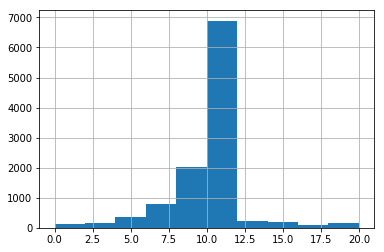

In [5]:
print(dataset.labels.dataframe)
counts = dataset.labels.dataframe.groupby('Category')['ID'].count()
array = np.array(counts)
print(array)
print(len(array))
dataset.labels.histogram()
# weights = max(counts)/array
# weights = torch.Tensor(weights).to(device)
# print(weights)
ratio = max(counts)/array



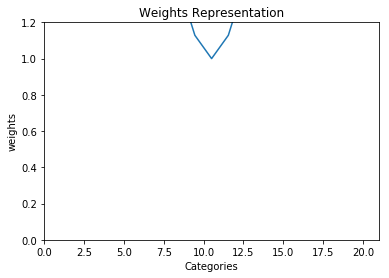

tensor([2.7547e+02, 4.4076e+02, 2.8995e+02, 2.5611e+02, 1.5042e+02, 9.9025e+01,
        4.9816e+01, 4.9868e+01, 1.7950e+01, 1.0891e+01, 1.6557e+00, 5.2702e+01,
        1.0187e+02, 3.0404e+02, 2.1919e+02, 2.2129e+02, 3.0083e+02, 8.1575e+02,
        4.6886e+02, 5.5095e+03, 2.2261e+02], device='cuda:0')


In [10]:
mu, variance = 10.5, 4
sigma = math.sqrt(variance) 
x = np.linspace(0, 21, 21)
pdf = stats.norm.pdf(x, mu, sigma)
inv = ((np.ones(len(x)) * (max(pdf))) - pdf)/max(pdf) + 1

plt.xlim([0,21])
plt.ylim([0,1.2])
plt.plot(x, inv)
plt.title("Weights Representation")
plt.xlabel("Categories")
plt.ylabel("weights")
plt.show()

weights = ratio * inv * 10
weights = torch.Tensor(weights).to(device)
print(weights)

In [11]:
from scipy.stats import uniform

uniform.cdf([0, 1, 2, 3, 4, 5], loc=1, scale=4)

array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

In [12]:
epochs = 30
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(type(weights))
criterion = nn.CrossEntropyLoss(weight=weights) # Changed from Mean-Squared to Cross-Entropy
#criterion = nn.MSELoss()
net.report_period = 20

net.optimizer = optimizer
#net.load("snapshots/1.217_model.pt")

net.fit(device,epochs,optimizer,criterion)

<class 'torch.Tensor'>
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([10, 12, 10, 10, 10,  8, 10, 10, 10, 10, 10, 17, 11,  8, 10, 10, 10, 11,
        10,  9, 11, 10, 10, 10,  9, 10, 10, 10,  9, 10, 10,  8, 10, 10, 20, 13,
        12,  8, 10,  9, 10,  9,  9, 10, 10, 10,  8, 10, 10,  9,  9, 10, 10,  8,
        18,  9,  3,  7, 10,  9, 10, 10,  8, 10, 10, 10, 11,  9, 10, 10, 10, 10,
        11, 10,  3, 10, 12,  9, 20, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10,
        10, 10,  9, 10, 10,  9, 10, 10, 11,  6,  8,  9, 10, 10,  5,  4,  9, 10,
        10, 10, 10, 10, 10, 10, 10,  4, 10, 10,

Accuracy: 3.125%
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([ 9, 10, 10, 10, 10,  9, 14, 15,  5, 10, 10,  1,  8, 13,  5, 10, 15, 10,
        10,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  8, 10,  6,
        10,  6, 10, 10, 10,  5, 10, 14,  9,  8, 10, 10, 10,  7, 10, 10, 10,  7,
        10,  7, 10, 10, 10, 10,  8, 10, 10, 10, 10,  9, 10, 10,  6, 10, 10, 10,
        10,  6, 10,  9, 10,  9,  9,  8, 10, 10, 10,  8, 10, 10,  8, 10, 10,  7,
         0,  8, 10, 10,  8, 10, 10,  9, 10, 10,  4,  8, 10, 10,  8, 10,  2,  9,
         4, 10,  9,  5, 10, 10, 10, 10,  9,  6,  9, 1

KeyboardInterrupt: 

In [ ]:
# End of training Validation Test
#net.load("snapshots/0.727_model.pt")
#total, correct = net.score(device,dataset, "categorical")

total = 0
correct = 0
for i_batch, sampled_batch in enumerate(dataset.validloader):
    images = sampled_batch['image'].to(device).float()
    controls = sampled_batch['control'].to(device).long()
    controls = torch.flatten(controls)
    prediction = net(images)

    maximum = torch.argmax(prediction,dim = 1)
    print(maximum)
    print(controls)
    shared = maximum == controls
    shared = 1 * shared
    correct += int(torch.sum(shared))
    total += len(controls)



print("{:.1f}% classified correctly".format(100*correct/total))

In [ ]:
# Beginning of training Validation Test
net.load("snapshots/3.002_model.pt")
total, correct = net.score(device,dataset, "categorical")
print("{:.1f}% classified correctly".format(100*correct/total))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Additional Info when using cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024))